<a href="https://colab.research.google.com/github/tylaar1/PICAR-autopilot/blob/main/GridSearchCV_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SWITCH TO **`T4 GPU`** OR THE **`HPC`**

# Imports

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt

In [ ]:
import platform
print(platform.system())

Linux


In [ ]:
# makes it so pd dfs aren't truncated

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
labels_file_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_norm.csv' # James file path
#labels_file_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025/training_norm.csv' # ben hpc file path (mlis2 cluster)
#labels_file_path = '/home/ppytr13/machine-learning-in-science-ii-2025/training_norm.csv' # tyler hpc file path (mlis2 cluster)
labels_df = pd.read_csv(labels_file_path, index_col='image_id')

In [ ]:
#image_folder_path = '/home/apyba3/KAGGLEDATAmachine-learning-in-science-ii-2025//training_data/training_data'
#image_folder_path = '/home/ppytr13/machine-learning-in-science-ii-2025//training_data/training_data'
image_folder_path = '/content/drive/MyDrive/machine-learning-in-science-ii-2025/training_data/training_data' # tylers file path
image_file_paths = [
    os.path.join(image_folder_path, f)
    for f in os.listdir(image_folder_path)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]

image_file_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) # sorts the files in the right order (1.png, 2.png, 3.png, ...)

imagefilepaths_df = pd.DataFrame(
    image_file_paths,
    columns=['image_file_paths'],
    index=[int(os.path.splitext(os.path.basename(path))[0]) for path in image_file_paths]
)

imagefilepaths_df.index.name = 'image_id'

we want to remove this row

In [ ]:
cleaned_df = merged_df[merged_df['speed'] != 1.428571]
cleaned_df.loc[3882:3886]

,angle,speed,image_file_paths
image_id,,,


In [ ]:
for images, labels in dataset.take(1):
    print(images.shape, labels.shape)

(32, 224, 224, 3) (32,)


image shape:  (224, 224, 3)
label: 1


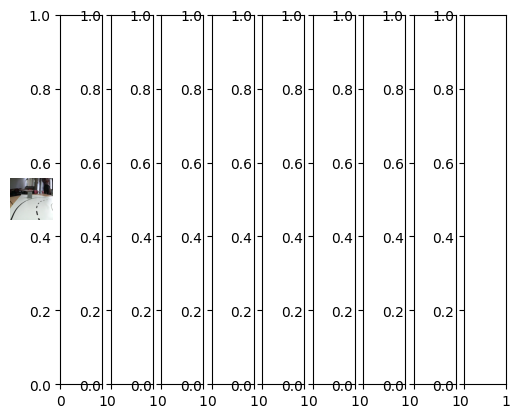

image shape:  (224, 224, 3)
label: 0
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 0
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 0
image shape:  (224, 224, 3)
label: 1
image shape:  (224, 224, 3)
label: 1


In [ ]:
f, axarr = plt.subplots(1,10)

i = 0
for image_batch, label_batch in dataset.take(1):  # Take one batch
    for image in image_batch:  # Iterate through images in the batch
        if i < 10:  # Only display the first 5 images
            print('image shape: ', np.shape(image))
            tf.print('label:', label_batch[i])  # Print label for the corresponding image
            axarr[i].imshow(image)
            axarr[i].axis('off')
            i += 1
        else:
            break  # Stop after displaying 5 images
        plt.show()

In [ ]:
dropoutrate = 0.2
num_classes = 1 # we're only predicting the prob of the positive class with a sigmoid
input_shape = (224,224,3)

mbnet = tf.keras.applications.MobileNetV3Large(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    minimalistic=False
)

model = tf.keras.Sequential([
  mbnet,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(dropoutrate),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])
model.build()

mbnet.trainable = False # freeze the first layers to the imagenet weights

model.summary() # print the model

In [ ]:
import tensorflow as tf

LR = 0.001  # learning rate
optimizer = tf.optimizers.Adam(LR)  # Adam optimizer

@tf.function
def train_step(model, X, Y):
    with tf.GradientTape() as tape:
        pred = model(X)  # Get the predictions from the model

        # Use binary cross-entropy for binary classification
        current_loss = tf.reduce_mean(tf.losses.binary_crossentropy(Y, pred))

    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Threshold predictions to binary values (0 or 1) for accuracy calculation
    pred_binary = tf.cast(pred > 0.5, dtype=tf.int32)  # Convert predictions to binary (0 or 1)

    # Calculate True Positives, False Positives, True Negatives, False Negatives
    TP = tf.reduce_sum(tf.cast((pred_binary == 1) & (Y == 1), dtype=tf.int32))
    TN = tf.reduce_sum(tf.cast((pred_binary == 0) & (Y == 0), dtype=tf.int32))
    FP = tf.reduce_sum(tf.cast((pred_binary == 1) & (Y == 0), dtype=tf.int32))
    FN = tf.reduce_sum(tf.cast((pred_binary == 0) & (Y == 1), dtype=tf.int32))

    # Calculate Balanced Accuracy
    sensitivity = TP / (TP + FN)  # Recall for class 1
    specificity = TN / (TN + FP)  # Recall for class 0
    balanced_accuracy = 0.5 * (sensitivity + specificity)

    return current_loss, balanced_accuracy


In [ ]:
niter = 50

tloss = []
tacc = []
vloss = []
vacc = []

for it in range(niter):
    # Training
    batch_losses = []
    batch_accs = []
    for image_batch, label_batch in train_dataset:
        # Convert labels to correct format for binary classification
        # Convert to [batch_size, 1] for binary classification with sigmoid
        labels = tf.expand_dims(tf.cast(label_batch, dtype=tf.float32), axis=1)
        loss, acc = train_step(model, image_batch, labels)
        batch_losses.append(loss)
        batch_accs.append(acc)

    # Average metrics for this epoch
    avg_loss = tf.reduce_mean(batch_losses).numpy()
    avg_acc = tf.reduce_mean(batch_accs).numpy()
    tloss.append(avg_loss)
    tacc.append(avg_acc)

    # LOGGING METRICS TO CHECK HOW TRAIING IS GOING

    if it % 10 == 0:
        tf.print(f'iter: {it}, train_loss: {avg_loss:.3f}, train_balanced_acc: {avg_acc:.3f}')

        # If you have a validation dataset, evaluate on it
        if 'val_dataset' in globals():
            val_losses = []
            val_accs = []
            for val_images, val_labels in val_dataset:
                val_labels = tf.expand_dims(tf.cast(val_labels, dtype=tf.float32), axis=1)
                val_preds = model(val_images)
                val_loss = tf.reduce_mean(tf.losses.binary_crossentropy(val_labels, val_preds))

                # Use the same balanced accuracy calculation as in train_step
                pred_binary = tf.cast(val_preds > 0.5, dtype=tf.int32)
                val_labels_int = tf.cast(val_labels, dtype=tf.int32)

                TP = tf.reduce_sum(tf.cast((pred_binary == 1) & (val_labels_int == 1), dtype=tf.int32))
                TN = tf.reduce_sum(tf.cast((pred_binary == 0) & (val_labels_int == 0), dtype=tf.int32))
                FP = tf.reduce_sum(tf.cast((pred_binary == 1) & (val_labels_int == 0), dtype=tf.int32))
                FN = tf.reduce_sum(tf.cast((pred_binary == 0) & (val_labels_int == 1), dtype=tf.int32))

                sensitivity = TP / (TP + FN + 1e-7)
                specificity = TN / (TN + FP + 1e-7)
                val_acc = 0.5 * (sensitivity + specificity)

                val_losses.append(val_loss)
                val_accs.append(val_acc)

            avg_val_loss = tf.reduce_mean(val_losses).numpy()
            avg_val_acc = tf.reduce_mean(val_accs).numpy()
            vloss.append(avg_val_loss)
            vacc.append(avg_val_acc)

            tf.print(f'val_loss: {avg_val_loss:.3f}, val_balanced_acc: {avg_val_acc:.3f}')

iter: 0, train_loss: 0.525, train_balanced_acc: 0.503


In [ ]:
niter = 50

tloss = []
tacc = []
vloss = []
vacc = []

for it in range(niter):
    # Training
    batch_losses = []
    batch_accs = []
    for image_batch, label_batch in train_dataset:
        # Convert labels to correct format for binary classification
        # Convert to [batch_size, 1] for binary classification with sigmoid
        labels = tf.expand_dims(tf.cast(label_batch, dtype=tf.float32), axis=1)
        loss, acc = train_step(model, image_batch, labels)
        batch_losses.append(loss)
        batch_accs.append(acc)

    # Average metrics for this epoch
    avg_loss = tf.reduce_mean(batch_losses).numpy()
    avg_acc = tf.reduce_mean(batch_accs).numpy()
    tloss.append(avg_loss)
    tacc.append(avg_acc)

    # LOGGING METRICS TO CHECK HOW TRAIING IS GOING

    if it % 10 == 0:
        tf.print(f'iter: {it}, train_loss: {avg_loss:.3f}, train_balanced_acc: {avg_acc:.3f}')

        # If you have a validation dataset, evaluate on it
        if 'val_dataset' in globals():
            val_losses = []
            val_accs = []
            for val_images, val_labels in val_dataset:
                val_labels = tf.expand_dims(tf.cast(val_labels, dtype=tf.float32), axis=1)
                val_preds = model(val_images)
                val_loss = tf.reduce_mean(tf.losses.binary_crossentropy(val_labels, val_preds))

                # Use the same balanced accuracy calculation as in train_step
                pred_binary = tf.cast(val_preds > 0.5, dtype=tf.int32)
                val_labels_int = tf.cast(val_labels, dtype=tf.int32)

                TP = tf.reduce_sum(tf.cast((pred_binary == 1) & (val_labels_int == 1), dtype=tf.int32))
                TN = tf.reduce_sum(tf.cast((pred_binary == 0) & (val_labels_int == 0), dtype=tf.int32))
                FP = tf.reduce_sum(tf.cast((pred_binary == 1) & (val_labels_int == 0), dtype=tf.int32))
                FN = tf.reduce_sum(tf.cast((pred_binary == 0) & (val_labels_int == 1), dtype=tf.int32))

                sensitivity = TP / (TP + FN + 1e-7)
                specificity = TN / (TN + FP + 1e-7)
                val_acc = 0.5 * (sensitivity + specificity)

                val_losses.append(val_loss)
                val_accs.append(val_acc)

            avg_val_loss = tf.reduce_mean(val_losses).numpy()
            avg_val_acc = tf.reduce_mean(val_accs).numpy()
            vloss.append(avg_val_loss)
            vacc.append(avg_val_acc)

            tf.print(f'val_loss: {avg_val_loss:.3f}, val_balanced_acc: {avg_val_acc:.3f}')

In [ ]:
#model.save_weights('/home/apyba3/car_unfrozen.weights.h5')
model.save_weights('/home/ppytr13/car_unfrozen.weights.h5')

In [ ]:
predictions_df = pd.DataFrame(predictions, columns=['speed'])

In [ ]:
predictions_df.head()

sigmoid output is between [0,1]

In [ ]:
predictions_df[predictions_df['speed'] > 0.5] = 1
predictions_df[predictions_df['speed'] < 0.5] = 0

In [ ]:
predictions_df.to_csv('/home/apyba3/mbnetv3_speedclassification_predictions.csv')

# Grid Search CV to tune the Hyperperameters

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Function to build the model with tunable hyperparameters
def build_model(learning_rate=0.001, dropout_rate=0.2):
    mbnet = tf.keras.applications.MobileNetV3Large(
        input_shape=(224,224,3),
        include_top=False,
        weights='imagenet'
    )
    mbnet.trainable = False  # Freeze base layers

    model = tf.keras.Sequential([
        mbnet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Regression output
    ])

    # Compiling the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='mean_squared_error',  # Adjust loss for regression
                  metrics=['mae'])
    return model

# Wrap the model using KerasRegressor for GridSearchCV
keras_regressor = KerasRegressor(build_fn=build_model, epochs=10, batch_size=32, verbose=0)

# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01],  # Test different learning rates
    'dropout_rate': [0.2, 0.3, 0.4],        # Tune dropout rate
    'batch_size': [32, 64],                 # Tune batch size
    'epochs': [10, 20]                      # Number of training epochs
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=keras_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)  # Replace X_train, y_train with your dataset

# Print best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best MAE score:", -grid_search.best_score_)


ModuleNotFoundError: No module named 'tensorflow.keras.wrappers.scikit_learn'

In [ ]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import keras_tuner as kt
import numpy as np
from sklearn.metrics import balanced_accuracy_score

# Defines a function to build the model with tunable hyperparameters
def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=hp.Int('conv1_filters', 32, 128, step=32), kernel_size=3, activation='relu', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(filters=hp.Int('conv2_filters', 32, 128, step=32), kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=hp.Int('dense_units', 64, 256, step=64), activation='relu'),
        tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', 0.2, 0.5, step=0.1)),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# deffineing training step
@tf.function
def train_step(model, train_dataset):
    for X_train, Y_train in train_dataset:
        with tf.GradientTape() as tape:
            pred = model(X_train)
            current_loss = tf.reduce_mean(tf.losses.binary_crossentropy(Y_train, pred))
        grads = tape.gradient(current_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        pred_binary = tf.cast(pred > 0.5, dtype=tf.int32)
        TP = tf.reduce_sum(tf.cast((pred_binary == 1) & (Y_train == 1), dtype=tf.int32))
        TN = tf.reduce_sum(tf.cast((pred_binary == 0) & (Y_train == 0), dtype=tf.int32))
        FP = tf.reduce_sum(tf.cast((pred_binary == 1) & (Y_train == 0), dtype=tf.int32))
        FN = tf.reduce_sum(tf.cast((pred_binary == 0) & (Y_train == 1), dtype=tf.int32))

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        balanced_acc = balanced_accuracy_score(Y_train.numpy(), pred_binary.numpy())

        return current_loss, accuracy, balanced_acc


(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_labels = (train_labels < 5).astype(int)  # Convert to binary classification

def preprocess_images(images):
    images = tf.image.resize(images, (64, 64))
    images = images / 255.0
    return images

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

# cvreates dataset pipeline
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(1000).batch(batch_size)

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='tuner_results',
    project_name='autonomous_car_tuning'
)

tuner.search(train_images, train_labels, epochs=10, validation_split=0.2)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# 6traines the best model
best_model = build_model(best_hps)
best_model.fit(train_images, train_labels, epochs=20, batch_size=best_hps.get('batch_size'))


Trial 10 Complete [00h 00m 57s]
val_accuracy: 0.7008000016212463

Best val_accuracy So Far: 0.7181000113487244
Total elapsed time: 00h 07m 11s

Search: Running Trial #11

Value             |Best Value So Far |Hyperparameter
96                |96                |conv1_filters
64                |128               |conv2_filters
256               |192               |dense_units
0.4               |0.4               |dropout_rate
0.00040536        |0.00066498        |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
 740/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5574 - loss: 0.6821